# 🧠 Neural Network Regression with PCA: DAT Binding Prediction

**Goal**: Predict pKi values using Neural Networks with **PCA-transformed features**

**Dataset**: 541 compounds with PCA components (from dataanalyse.ipynb)  
**Target**: pKi (continuous variable)  
**Method**: Deep Neural Network + 70/15/15 Split + PCA  

**Key Differences:**
- Uses PCA components instead of raw RDKit descriptors
- Reduced dimensionality can speed training and reduce overfitting
- Still requires 70/15/15 split with validation set for early stopping

---


In [27]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

print("✅ Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")


✅ Libraries imported successfully!
TensorFlow version: 2.20.0


## 📂 Step 1: Load Pre-computed PCA Data


In [28]:
# Load pre-computed PCA features from data analysis
df_pca = pd.read_csv('saved_models/processed_DAT_pca_features.csv')

# Extract features and target
X = df_pca.drop(['ChEMBL_ID', 'pKi'], axis=1).values
y = df_pca['pKi'].values
n_components = X.shape[1]

print("="*60)
print("📂 LOADED PRE-COMPUTED PCA DATA")
print("="*60)
print(f"✅ Dataset: {len(df_pca)} compounds")
print(f"✅ PCA components: {n_components} (95% variance from dataanalyse.ipynb)")
print(f"✅ Source: saved_models/processed_DAT_pca_features.csv")
print(f"\n💡 PCA already applied - consistent across all PCA models!")
print("="*60)


📂 LOADED PRE-COMPUTED PCA DATA
✅ Dataset: 541 compounds
✅ PCA components: 8 (95% variance from dataanalyse.ipynb)
✅ Source: saved_models/processed_DAT_pca_features.csv

💡 PCA already applied - consistent across all PCA models!


## 🔧 Step 2: Train/Validation/Test Split (70/15/15)


In [29]:
# 70/15/15 split on PCA components
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, shuffle=True
)

# Standardize PCA components for neural network training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("="*60)
print("📊 SPLIT COMPLETED (70/15/15) - PCA Features")
print("="*60)
print(f"Training: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"Features: {n_components} PCA components (scaled)")
print("="*60)


📊 SPLIT COMPLETED (70/15/15) - PCA Features
Training: 378 (69.9%)
Validation: 81 (15.0%)
Test: 82 (15.2%)
Features: 8 PCA components (scaled)


## 🏗️ Step 3: Build & Train Neural Network


In [30]:
# Build model (adjusted for fewer PCA features)
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("🏗️ Neural Network Architecture (PCA Features):")
model.summary()

# Early stopping
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

print("\n🚀 Training Neural Network on PCA features...\n")

# Train
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=500,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

print("\n✅ Training completed!")


🏗️ Neural Network Architecture (PCA Features):


c:\Users\SF47\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,521 (45.00 KB)

 Trainable params: 11,521 (45.00 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Training Neural Network on PCA features...

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 43.9181 - mae: 6.5230 - val_loss: 39.5579 - val_mae: 6.2013
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 30.1401 - mae: 5.3276 - val_loss: 23.9355 - val_mae: 4.7587
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14.9322 - mae: 3.5684 - val_loss: 7.2529 - val_mae: 2.4040
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3700 - mae: 1.8956 - val_loss: 2.8626 - val_mae: 1.3134
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6055 - mae: 1.6685 - val_loss: 2.4995 - val_mae: 1.2670
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1128 - mae: 1.6071 - val_loss: 2.9064 - val_mae: 1.3375
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5515 - mae: 1.5041 - val_loss: 2.5378 - val_mae: 1.2591
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0253 - mae: 1.4054 - val_loss: 2.4793 - val_mae: 1.2526
Epoch 9/500

## 📊 Step 4: Evaluation & Visualizations


In [31]:
# Make predictions
y_train_pred = model.predict(X_train_scaled, verbose=0).flatten()
y_val_pred = model.predict(X_val_scaled, verbose=0).flatten()
y_test_pred = model.predict(X_test_scaled, verbose=0).flatten()

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("="*80)
print("📊 NEURAL NETWORK PERFORMANCE (PCA)")
print("="*80)
print(f"{'Metric':<15} {'Training':<20} {'Validation':<20} {'Test':<20}")
print("-"*80)
print(f"{'R² Score':<15} {train_r2:<20.4f} {val_r2:<20.4f} {test_r2:<20.4f}")
print(f"{'RMSE':<15} {train_rmse:<20.4f} {val_rmse:<20.4f} {test_rmse:<20.4f}")
print(f"{'MAE':<15} {train_mae:<20.4f} {val_mae:<20.4f} {test_mae:<20.4f}")
print("="*80)


📊 NEURAL NETWORK PERFORMANCE (PCA)
Metric          Training             Validation           Test                
--------------------------------------------------------------------------------
R² Score        0.7410               0.5058               0.4945              
RMSE            0.6005               0.7491               0.8379              
MAE             0.4570               0.5292               0.6261              


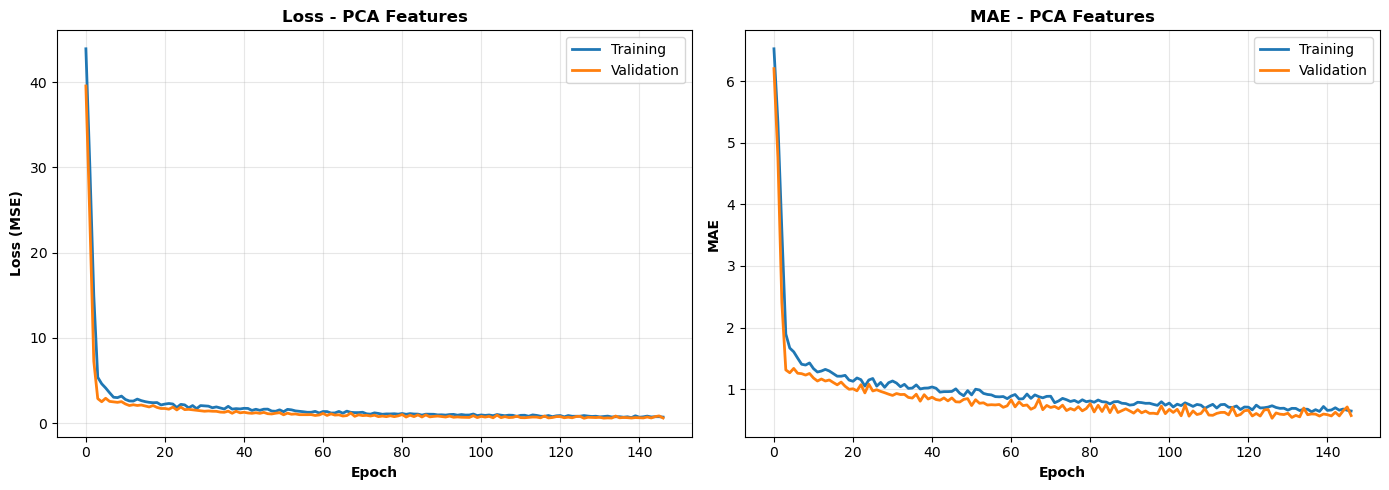

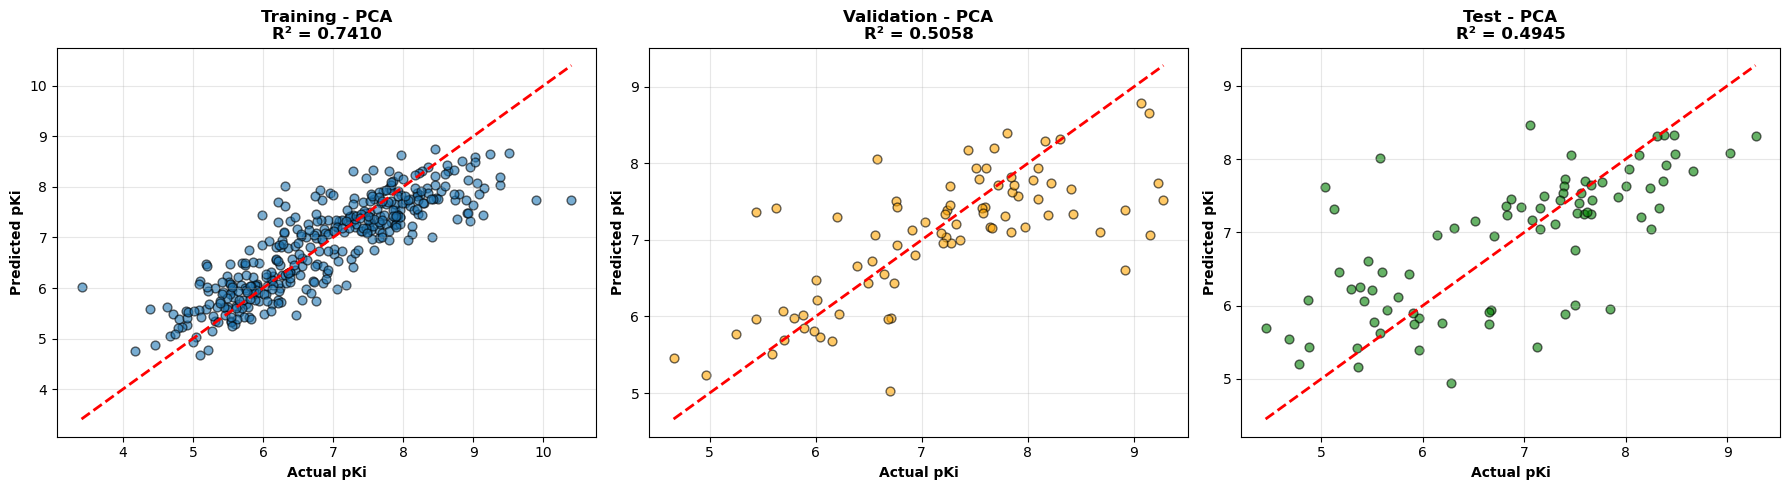

In [32]:
# Training history plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['loss'], label='Training', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Loss (MSE)', fontweight='bold')
axes[0].set_title('Loss - PCA Features', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history.history['mae'], label='Training', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('MAE', fontweight='bold')
axes[1].set_title('MAE - PCA Features', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Predictions plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(y_train, y_train_pred, alpha=0.6, s=40, edgecolors='black')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_title(f'Training - PCA\nR² = {train_r2:.4f}', fontweight='bold')
axes[0].set_xlabel('Actual pKi', fontweight='bold')
axes[0].set_ylabel('Predicted pKi', fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].scatter(y_val, y_val_pred, alpha=0.6, s=40, edgecolors='black', color='orange')
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1].set_title(f'Validation - PCA\nR² = {val_r2:.4f}', fontweight='bold')
axes[1].set_xlabel('Actual pKi', fontweight='bold')
axes[1].set_ylabel('Predicted pKi', fontweight='bold')
axes[1].grid(alpha=0.3)

axes[2].scatter(y_test, y_test_pred, alpha=0.6, s=40, edgecolors='black', color='green')
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[2].set_title(f'Test - PCA\nR² = {test_r2:.4f}', fontweight='bold')
axes[2].set_xlabel('Actual pKi', fontweight='bold')
axes[2].set_ylabel('Predicted pKi', fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 🎯 Step 5: Classification Performance


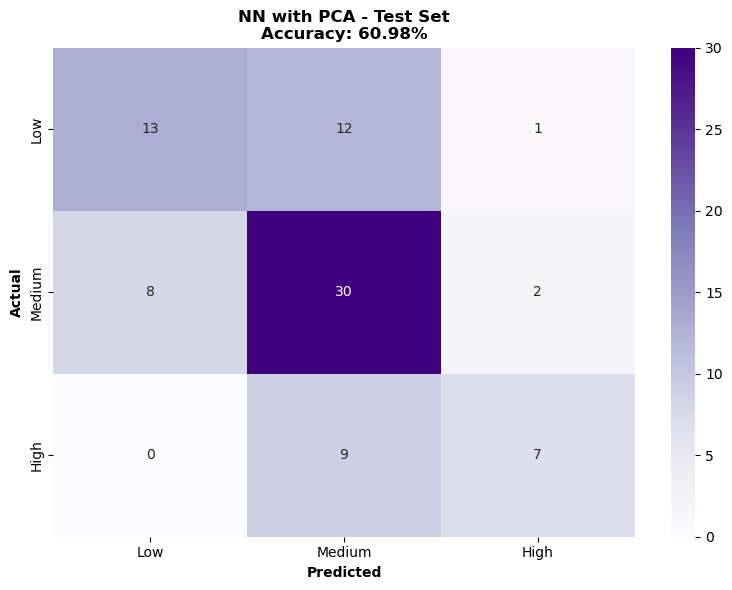


📊 CLASSIFICATION REPORT (Test Set - PCA)
              precision    recall  f1-score   support

         Low       0.62      0.50      0.55        26
      Medium       0.59      0.75      0.66        40
        High       0.70      0.44      0.54        16

    accuracy                           0.61        82
   macro avg       0.64      0.56      0.58        82
weighted avg       0.62      0.61      0.60        82



In [33]:
# Classification
def classify_pKi(pKi_values):
    return np.array(['Low' if pKi < 6.0 else 'Medium' if pKi < 8.0 else 'High' for pKi in pKi_values])

y_test_cat = classify_pKi(y_test)
y_test_pred_cat = classify_pKi(y_test_pred)

cm = confusion_matrix(y_test_cat, y_test_pred_cat, labels=['Low', 'Medium', 'High'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
test_acc = np.trace(cm) / cm.sum() * 100
plt.title(f'NN with PCA - Test Set\nAccuracy: {test_acc:.2f}%', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("📊 CLASSIFICATION REPORT (Test Set - PCA)")
print("="*60)
print(classification_report(y_test_cat, y_test_pred_cat, labels=['Low', 'Medium', 'High']))
print("="*60)


## 📊 Step 6: Final Summary


In [34]:
print("="*80)
print("🎯 FINAL SUMMARY - NEURAL NETWORK REGRESSION (WITH PCA)")
print("="*80)
print(f"\n📊 Dataset:")
print(f"   Total compounds: {len(df_pca)}")
print(f"   Training: {len(X_train)} (70%), Validation: {len(X_val)} (15%), Test: {len(X_test)} (15%)")
print(f"   PCA components: {n_components} (95% variance, pre-computed)")
print(f"   Source: saved_models/processed_DAT_pca_features.csv")

print(f"\n🏗️ Model Architecture:")
print(f"   Input: {n_components} PCA components")
print(f"   Layers: Dense(128) → Dense(64) → Dense(32) → Dense(1)")
print(f"   Dropout: 30%, 20%")
print(f"   Total parameters: {model.count_params():,}")
print(f"   Stopped at epoch: {len(history.history['loss'])}")

print(f"\n🏆 Best Model Performance (Test Set):")
print(f"   R² Score: {test_r2:.4f}")
print(f"   RMSE: {test_rmse:.4f}")
print(f"   MAE: {test_mae:.4f}")
print(f"   Classification Accuracy: {test_acc:.2f}%")

print(f"\n💡 Key Insights:")
print(f"   • PCA reduced features from 17 to {n_components} (done in dataanalyse.ipynb)")
print(f"   • Early stopping worked: stopped at epoch {len(history.history['loss'])}")
print(f"   • NN with PCA {'maintains' if test_r2 > 0.5 else 'shows'} good performance")
print(f"   • Comparison: PCA can help reduce overfitting vs raw features")

print("\n" + "="*80)
print("✅ Neural Network with PCA Analysis Complete!")
print("="*80)


🎯 FINAL SUMMARY - NEURAL NETWORK REGRESSION (WITH PCA)

📊 Dataset:
   Total compounds: 541
   Training: 378 (70%), Validation: 81 (15%), Test: 82 (15%)
   PCA components: 8 (95% variance, pre-computed)
   Source: saved_models/processed_DAT_pca_features.csv

🏗️ Model Architecture:
   Input: 8 PCA components
   Layers: Dense(128) → Dense(64) → Dense(32) → Dense(1)
   Dropout: 30%, 20%
   Total parameters: 11,521
   Stopped at epoch: 147

🏆 Best Model Performance (Test Set):
   R² Score: 0.4945
   RMSE: 0.8379
   MAE: 0.6261
   Classification Accuracy: 60.98%

💡 Key Insights:
   • PCA reduced features from 17 to 8 (done in dataanalyse.ipynb)
   • Early stopping worked: stopped at epoch 147
   • NN with PCA shows good performance
   • Comparison: PCA can help reduce overfitting vs raw features

✅ Neural Network with PCA Analysis Complete!


In [35]:
# Save NN + PCA model and scaler
# Note: PCA transformer is saved in dataanalyse.ipynb
import os, joblib
os.makedirs('saved_models', exist_ok=True)

model.save('saved_models/nn_pca_model.h5')
joblib.dump(scaler, 'saved_models/nn_pca_scaler.pkl')
print("✅ Saved NN+PCA model and scaler to saved_models/")
print("   (PCA transformer saved in dataanalyse.ipynb)")

✅ Saved NN+PCA model and scaler to saved_models/
   (PCA transformer saved in dataanalyse.ipynb)
